## Modelado de Series de tiempo

### Objetivo

Predecir el valor de un producto dado un historico de precios.


Integrantes:
- Nery Fuentes - 15004337
- Luis Barreno - 24007314


In [ ]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

In [ ]:


# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

### Cargar datos

In [4]:
df = pd.read_csv("datos.csv")

### Análisis Exploratorio

In [6]:
df.head()

,Month,price
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   331 non-null    object 
 1   price   331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [7]:
df.tail()

,Month,price
326,2019-03-01,9718.107698
327,2019-04-01,9248.814254
328,2019-05-01,10001.305304
329,2019-06-01,9431.337229
330,2019-07-01,9887.800688


In [ ]:
#convertir a fecha

df['Month'] = pd.to_datetime(df['Month'])


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   331 non-null    datetime64[ns]
 1   price   331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


In [10]:
df.head()

,Month,price
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [ ]:
# convertir la fecha a indice

df = df.set_index("Month")
df.head()

,price
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [11]:
fig = px.line(df, x =df.index, y="price",template="plotly_white", title="Precio de venta")
fig.show()

count      331.000000
mean      5975.765787
std       2092.867819
min       2073.432724
25%       4280.088499
50%       6075.405272
75%       7381.403461
max      10833.501852
Name: price, dtype: float64

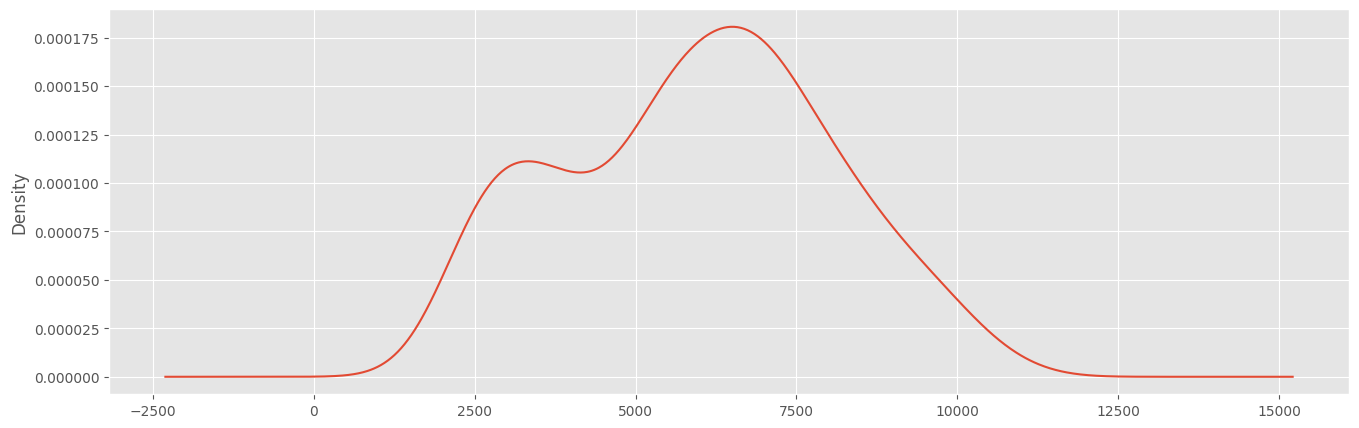

In [12]:
df["price"].plot(kind="kde", figsize=(16,5))
df["price"].describe()

In [12]:
data = df.copy()

Text(0.5, 0.98, '')

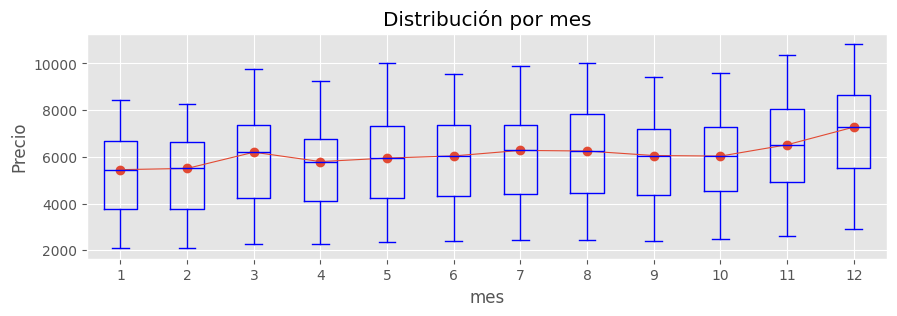

In [14]:
fig, ax = plt.subplots(figsize=(10,3))
data["mes"] = data.index.month
data.boxplot(column="price", by="mes", ax =ax , color="blue")
data.groupby("mes")["price"].median().plot(style="o-", linewidth=0.8, ax=ax)
ax.set_ylabel("Precio")
ax.set_title("Distribución por mes")
fig.suptitle("")

Text(0.5, 0.98, '')

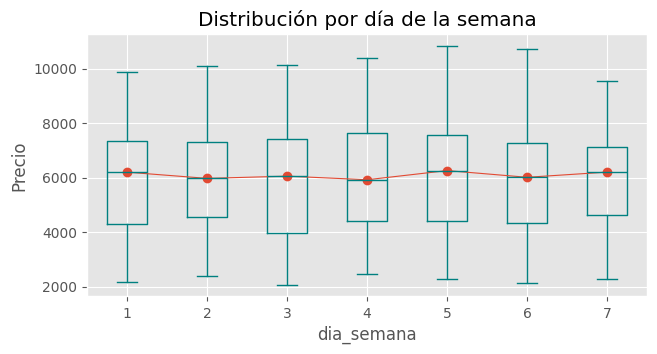

In [15]:
fig, ax = plt.subplots(figsize=(7,3.5))
data["dia_semana"] = data.index.day_of_week+1
data.boxplot(column="price", by="dia_semana", ax =ax , color="teal")
data.groupby("dia_semana")["price"].median().plot(style="o-", linewidth=0.8, ax=ax)
ax.set_ylabel("Precio")
ax.set_title("Distribución por día de la semana")
fig.suptitle("")

### Prueba Dickey-Fuller

In [ ]:
# H0: The time series is non-stationary.
# HA: The time series is stationary.
# IF p < 0.5 Reject H0

def Prueba_DFuller(dataFrame , columna):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {columna}')
    dftest = adfuller(dataFrame, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos NO son estacionarios")

In [17]:
Prueba_DFuller(df["price"],"price")

Resultados de la prueba de Dickey-Fuller para columna: price
Test Statistic                         -1.128551
p-value                                 0.703553
No Lags Used                           14.000000
Número de observaciones utilizadas    316.000000
Critical Value (1%)                    -3.451215
Critical Value (5%)                    -2.870730
Critical Value (10%)                   -2.571666
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [18]:
df1 = df.copy()

df1["price_diff"]=df["price"].diff()

df1.dropna(inplace=True)

df1.head()

,price,price_diff
Month,,
1992-02-01,2114.485812,41.053088
1992-03-01,2260.570891,146.085079
1992-04-01,2255.103236,-5.467655
1992-05-01,2331.414618,76.311382
1992-06-01,2384.638567,53.223949


In [19]:
Prueba_DFuller(df1["price_diff"],"price_diff")

Resultados de la prueba de Dickey-Fuller para columna: price_diff
Test Statistic                         -3.117451
p-value                                 0.025288
No Lags Used                           17.000000
Número de observaciones utilizadas    312.000000
Critical Value (1%)                    -3.451484
Critical Value (5%)                    -2.870849
Critical Value (10%)                   -2.571730
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


In [20]:
fig = px.line(df1, x=df1.index, y ="price_diff", title ="Precio de venta")
fig.show()


### Autocorrelación

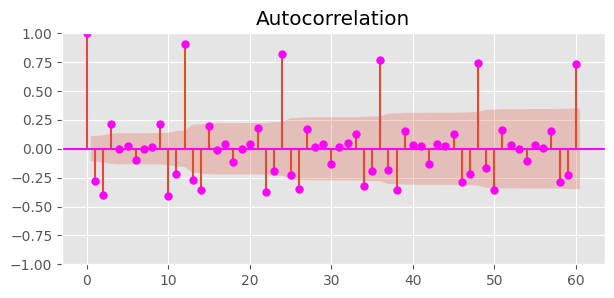

In [21]:
fig, ax = plt.subplots(figsize =(7,3))
plot_acf(df1["price_diff"], ax= ax, lags =60, color="fuchsia")
plt.show()

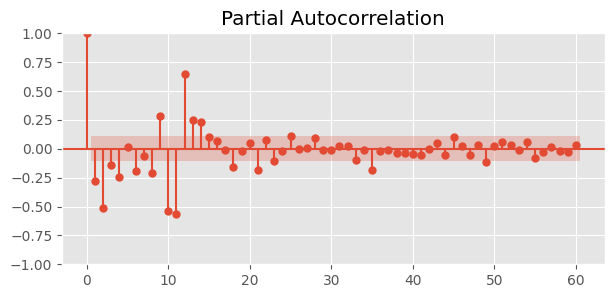

In [22]:
fig, ax = plt.subplots(figsize=(7,3))
plot_pacf(df1["price_diff"], ax= ax, lags=60)
plt.show()

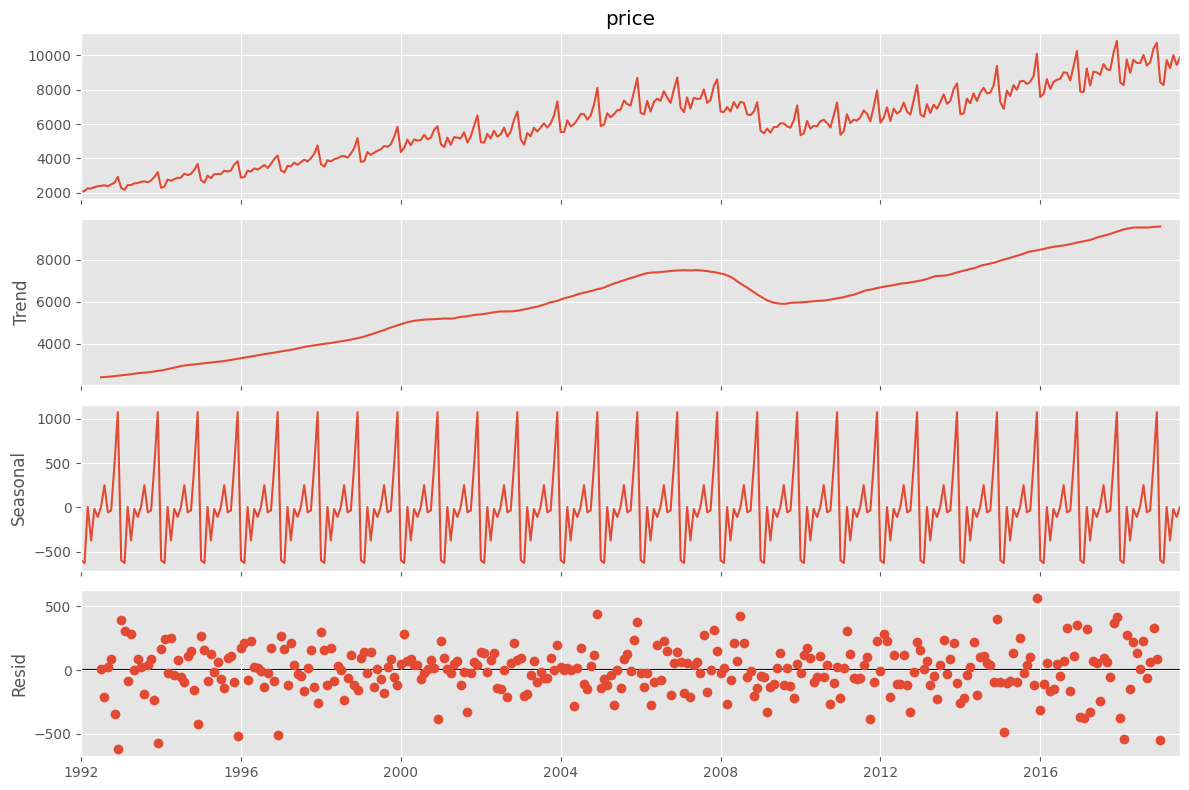

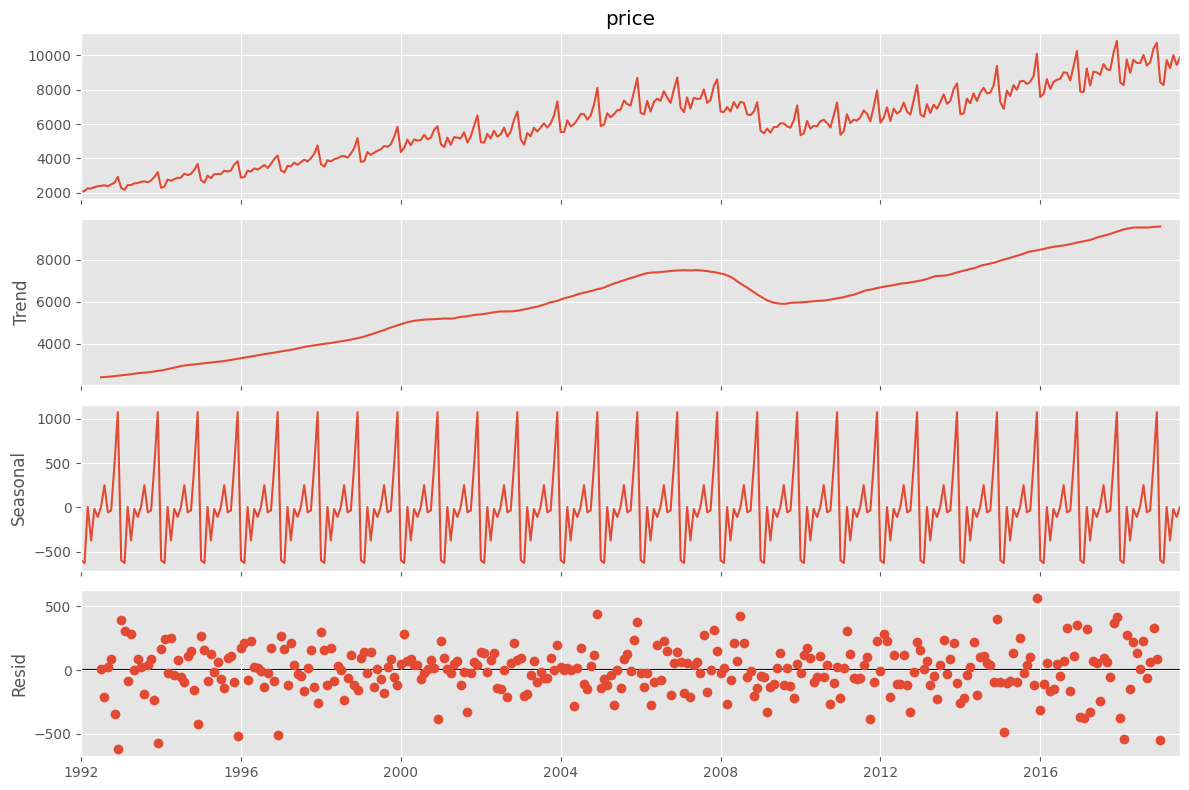

In [23]:
plt.rcParams["figure.figsize"] =(12,8)
a = seasonal_decompose(df["price"], model ="add")
a.plot()

### Division de datos

In [13]:
train_data = df[:len(df)-16]
test_data = df[len(df)-16:]

test = test_data.copy()
train_data.shape, test_data.shape

((315, 1), (16, 1))

### Datos de entrenamiento

In [14]:
train_data.head()

,price
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


### Datos de prueba

In [15]:
test_data.head()

,price
Month,
2018-04-01,8973.885759
2018-05-01,9733.086145
2018-06-01,9554.807941
2018-07-01,9542.663403
2018-08-01,10010.598100


### Modelo Auto - Arima

In [16]:


from pmdarima import auto_arima   

In [17]:
#parmetro M (7 para dias, 12 para meses, 52 para semanas, 4 trimestral, 1 anual)

modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4117.823, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4054.624, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4026.240, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4044.237, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4011.516, Time=0.65 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4036.052, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4007.981, Time=1.55 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4025.877, Time=0.91 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3996.156, Time=3.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4010.309, Time=1.53 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=3998.114, Time=3.66 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=3998.093, Time=4.38 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(1,1,2)(2,1,2)[12]     

In [18]:
print(modelo_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  315
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1992.078
Date:                                 Sun, 08 Dec 2024   AIC                           3996.156
Time:                                         16:37:19   BIC                           4018.418
Sample:                                     01-01-1992   HQIC                          4005.063
                                          - 03-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4004      0.043     -9.213      0.000      -0.486      -0

### Entenamiento del modelo

In [19]:
arima_model = SARIMAX(train_data["price"], order = (0,1,1), seasonal_order = (2,1,2,12)).fit()

### Residuos

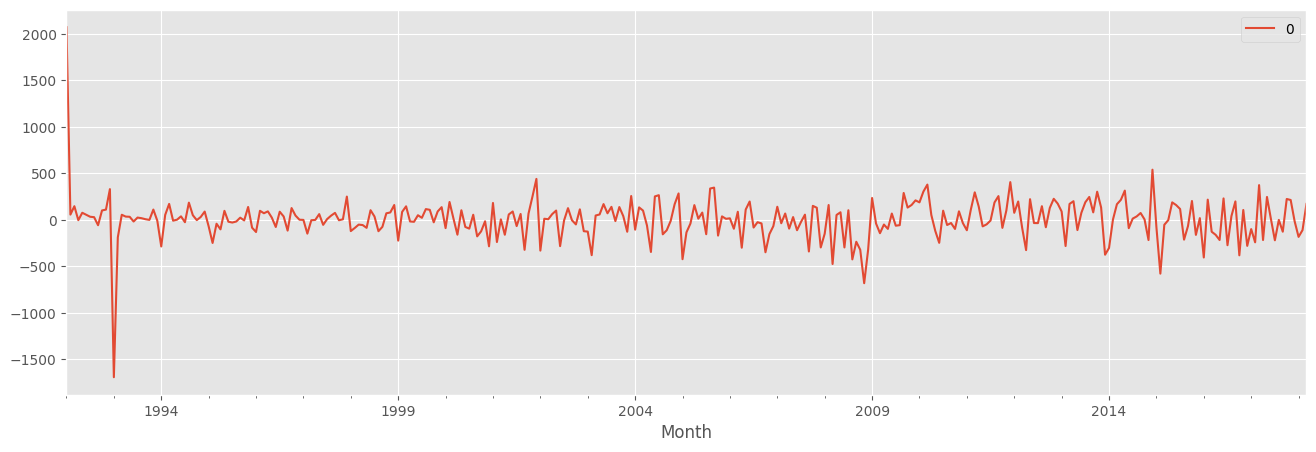

In [20]:
#residuales
residuals = pd.DataFrame(arima_model.resid)
residuals.plot(figsize = (16,5));
plt.show();

### Evaluación del model

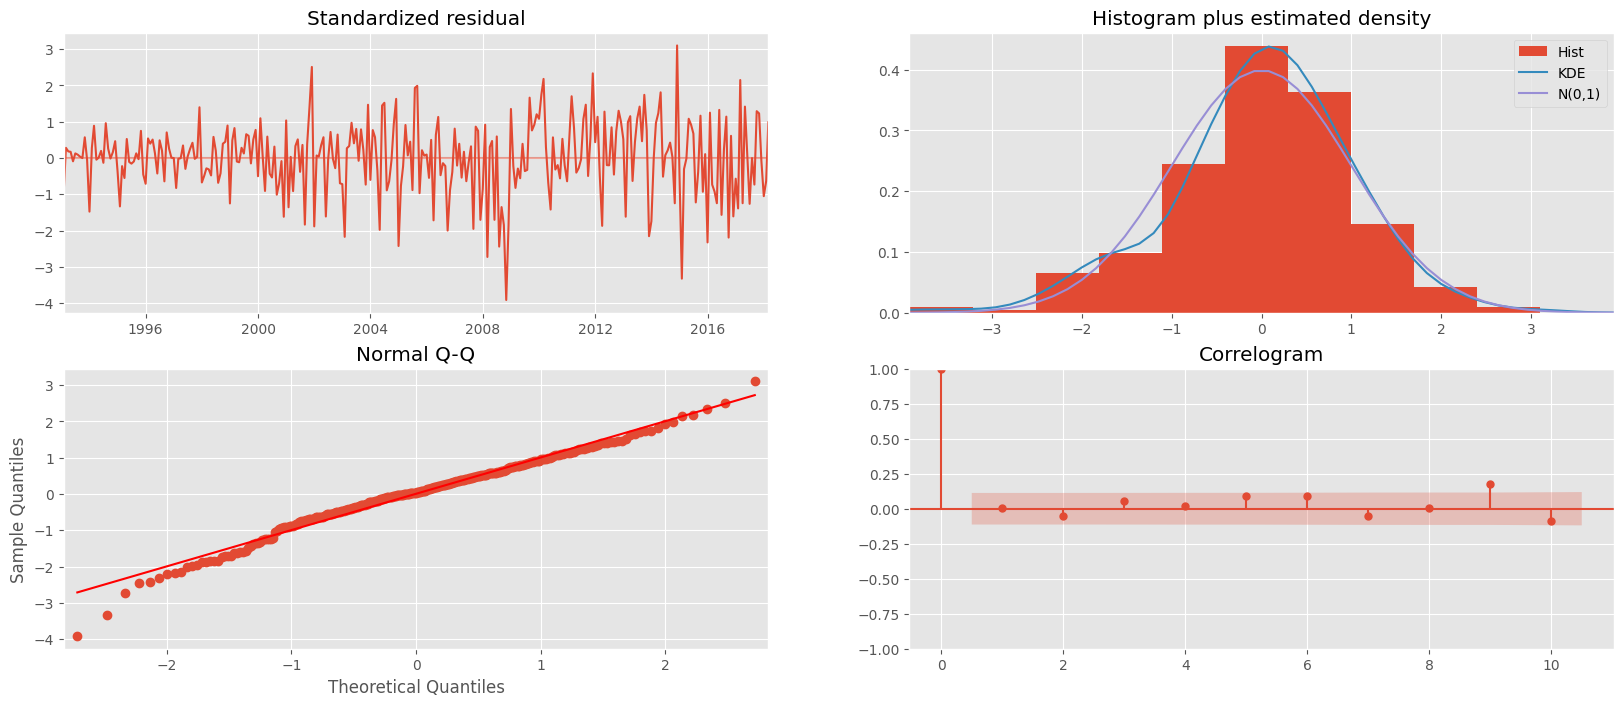

In [21]:
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

### Predicciones del modelo


In [22]:
arima_pred = arima_model.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")

In [ ]:
#arima_pred2 = arima_model.predict(start='2015-01-01',end='2025-01-01', typ="levels").rename("ARIMA Predictions")

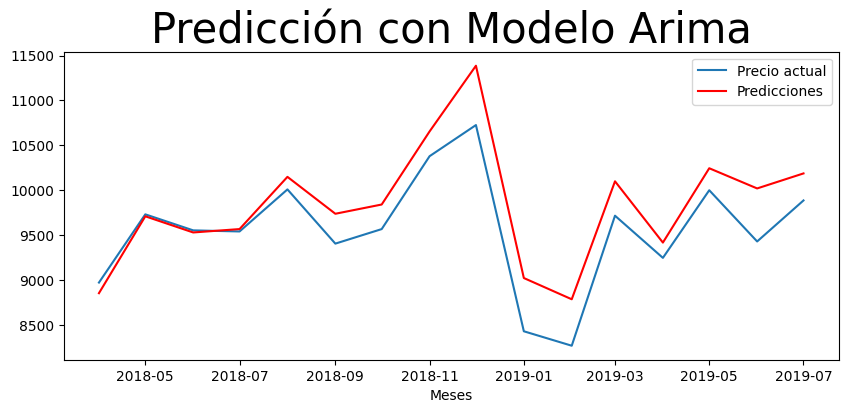

In [79]:

plt.style.use('default')
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(test_data["price"], label="Precio actual")
plt.plot(arima_pred, color="red", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=10);
plt.show();

### Evaluación del Modelo

In [25]:
def evaluacion_modelo(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [26]:

evaluacion_modelo(test_data,arima_pred)

Evaluation metric results:-
MSE is : 126519.46072275713
MAE is : 291.78284887394534
RMSE is : 355.69574178327906
MAPE is : 7.786926018459052
R2 is : 0.6630395328518559



### Guardar resultados de la predicción

In [27]:
test_data["Arima_Pred"]= arima_pred

In [28]:
test_data.head()

,price,Arima_Pred
Month,,
2018-04-01,8973.885759,8855.800807
2018-05-01,9733.086145,9711.358737
2018-06-01,9554.807941,9531.477028
2018-07-01,9542.663403,9569.197139
2018-08-01,10010.598100,10150.248320


### Implementar Prophet

In [107]:
from prophet import Prophet


In [108]:
df3 = df.copy()
df3.head()

,price
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [109]:
df3=df3.reset_index()

### Renombrar columnas del dataframe

In [110]:
df_fb=df3.rename(columns={"Month":"ds", "price":"y"} )
df_fb.head()

,ds,y
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [111]:
train_data_pr = df_fb.iloc[:len(df3)-12]
test_data_pr = df_fb.iloc[len(df3)-12:]

### Crear modelo Prophet

In [112]:
m = Prophet()

# Hacemos el entrenamiento
m.fit(train_data_pr)

17:35:28 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [98]:
prophet_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,2241.484034,1347.784995,1918.227266,2241.484034,2241.484034,-611.829379,-611.829379,-611.829379,-611.829379,-611.829379,-611.829379,0.0,0.0,0.0,1629.654655
1,1992-02-01,2265.392674,1423.815230,1978.510963,2265.392674,2265.392674,-571.221181,-571.221181,-571.221181,-571.221181,-571.221181,-571.221181,0.0,0.0,0.0,1694.171494
2,1992-03-01,2287.758822,2045.788306,2579.511039,2287.758822,2287.758822,31.273129,31.273129,31.273129,31.273129,31.273129,31.273129,0.0,0.0,0.0,2319.031951
3,1992-04-01,2311.667463,1649.034236,2226.802707,2311.667463,2311.667463,-368.167913,-368.167913,-368.167913,-368.167913,-368.167913,-368.167913,0.0,0.0,0.0,1943.499550
4,1992-05-01,2334.804857,1983.988922,2554.683832,2334.804857,2334.804857,-69.590425,-69.590425,-69.590425,-69.590425,-69.590425,-69.590425,0.0,0.0,0.0,2265.214432


In [114]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-16:]['ds'], "Pred" : prophet_pred[-16:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"

In [115]:

prophet_pred.head()

,Pred
Date,
2018-04-01,9068.605396
2018-05-01,9469.342788
2018-06-01,9415.874090
2018-07-01,9566.331074
2018-08-01,9843.414274


In [116]:
a=test_data[["price","Prophet_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_white",
              title="Predicción con Modelo Prophet")
fig.show()

In [117]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [118]:
test_data

,price,Arima_Pred,Prophet_Predictions
Month,,,
2018-04-01,8973.885759,8855.800807,9068.605396
2018-05-01,9733.086145,9711.358737,9469.342788
2018-06-01,9554.807941,9531.477028,9415.874090
2018-07-01,9542.663403,9569.197139,9566.331074
2018-08-01,10010.598100,10150.248320,9843.414274
2018-09-01,9407.297340,9739.570566,9583.402638
2018-10-01,9569.037851,9842.498008,9629.978277
2018-11-01,10380.194097,10655.821698,10177.888044
2018-12-01,10726.595075,11386.869489,10835.885582


In [119]:
evaluacion_modelo(test_data["price"],test_data["Prophet_Predictions"])

Evaluation metric results:-
MSE is : 128480.18929659855
MAE is : 248.29694818963458
RMSE is : 358.4413331308187
MAPE is : 2.7481041146281595
R2 is : 0.6578175060393952



In [120]:
fig = px.line(test_data, x=test_data.index, y=test_data.columns,template = "plotly_white",
              title="Predicciones")
fig.show()

## Conclusión

Los modelos presentan las siguientes metrias:

MAPE (Mean Absolute Percentage Error)

- Modelo Sarima: 7.79%
- Modelo Prophet: 2.75% 

MAE (Mean Absolute Error):

- Modelo Sarima :  291.78284887394534
- Modelo Prophet : 248.29694818963458

Dado que MAPE es una métrica crucial en problemas donde la precisión relativa es importante se elige el Modelo Prophet como la mejor opcion para este caso en particular